In [74]:
import numpy as np
import pandas as pd
import re
from collections import defaultdict, Counter
from scipy.sparse import csr_matrix
import scipy.sparse
pd.set_option('display.max_colwidth', None)
from tqdm.notebook import tqdm
import time
import math
import matplotlib.pyplot as plt
np.set_printoptions(edgeitems=10)

## Part1 : Representing Text Data

In [75]:
df = pd.read_csv('train.csv')
df.head(1)

,party_affiliation,email_text,uid_email
0,Democratic Party,"⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱ \n Stop <NORP> is proudly dedicated to doing what we do best-- connecting with voters one on one to increase <PARTY> voter turnout. If you only want our most important email updates or to unsubscribe, click here. \n YES! YES! YES! \n FIRST: <PERSON> <PERSON> sliced through <ORG> <ORG> ’s <ORG> <ORG>. \n SO: We sounded the alarm… and you heard us. \n NOW! <NORP> EVERYWHERE ARE DONATING TO <> <> <>: \n 500%-MATCH ACTIVE: $ 210,421 Raised to <PERSON> <PERSON> \n 500%-Match: Donate to <PERSON> <PERSON> → \n It ’s HAPPENING: <PERSON> <PERSON> IS OVER! \n If we can fill our <PERSON> <PERSON> <PERSON>, he ’ll be DONE for… and the <ORG> is OURS! [ YES] \n But we still need $ 29,101 before MIDNIGHT. Can you chip in $ 5( worth $ 25 500%‑MATCHED)? \n 500 % MATCH: $ 5 → \n 500 % MATCH: $ 25 → \n 500 % MATCH: $ 50 → \n 500 % MATCH: $ 100 → \n 500 % MATCH: $ 250 → \n Or donate another amount → \n THIS IS IT! \n [[ URL <>]] \n This message was sent to: [[ EMAIL_REDACTED]] \n Click here to receive fewer emails. | Click here to unsubscribe. \n <ORG> <ORG>— <GPE> \n <> <> <> \n <PERSON> <PERSON> has never been more vulnerable. His approval numbers are the worst in the country. \n It ’s critical that we defeat <PERSON> in 2020. Chip in now to beat <> and win a <PARTY> <ORG>: \n 500 % MATCH: Donate Now → \n PAID FOR BY <> <> <> \n ([[ URL <>]]) AND NOT AUTHORIZED BY ANY <ORG> OR <ORG> 'S <ORG> \n This message was sent to: [[ EMAIL_REDACTED ]] | Change or update your email address by clicking here. \n Stop <NORP>, an accountability project of <ORG> <ORG> <ORG>, is a grassroots- funded effort dedicated to resisting the <ORG> <ORG> and <PERSON> <PERSON> 's radical right wing agenda. \n We believe that emails are a crucial way for our campaign to stay in touch with supporters like you. However, if you 'd prefer to receive fewer emails, you can click here. If you would like to unsubscribe, click here. \n Our movement is powered by supporters like you. Your grassroots support is critical to helping us defeat <NORP> across the country. If you 'd like to donate, please click here. Thanks for your support! \n Stop <NORP> \n <> <> 618293 \n",3083493a6b205eabd8d0f1e7772db09b


### Task 1.1 Tokenization

In [76]:
def tokenize(text):
    token_list = text.split()
    return token_list

def better_tokenize(text):
    text = re.sub('(?<=[$])\s+','',text) # remove spaces after dollar sign
    text = re.sub('\s+(?=%)','',text) # remove spaces before percentage sign
    text = re.sub("'","’",text) # fix apostrophes
    text = re.sub("\s+(?=’)",'',text) # remove spaces before apostrophe
    token_list = re.split('\s+|(?<!\d)[,.]|[,.](?!\d)|[-—‑–»:;#?!*…⋱^→➞↴|()&“”"/\[\]\\\]+|(?<!\w)[>]|[<](?!\w)|(?<!\w)[_]|[_](?!\w)',text)
    token_list = list(filter(None, token_list))
    return token_list

In [77]:
doc_list = df['email_text'].to_list()

In [5]:
token_dict = Counter() # Counting all words for all documents and putting into a dictionary
for doc in doc_list:
    token_dict.update(Counter(better_tokenize(doc.lower())))

In [6]:
def remove_tokens(word_list):  
    stop_words = ['to','the','and','you','for','in','a','of','our','we','this','these','into'
                  'is','your','on','by','that','with','are','can','from','or','i','there'
                  'us','have','be','so','do','does','doing','did','it','at','was','were','who'
                  'what','how','has','had','an','as','my','about','it’s','any','i’m','that’s'
                  'me','they','they’ll','them','because','how','am','can','too','very','many',
                  'such','we’re','some','where','why','would','would’nt','does’nt','is’nt']
    rare_words = [i for i,k in token_dict.items() if k < 10]
    remove_words = stop_words + rare_words
    final_tokens = [i for i in word_list if i not in remove_words]
    return final_tokens

In [7]:
uniq_words = set() # A set of unique words for all documents
for doc in doc_list:
    uniq_words.update(better_tokenize(doc.lower()))
final_tokens = remove_tokens(uniq_words)
    
words_index_dict = {}
for i, word in list(enumerate(sorted(final_tokens))):
    words_index_dict[word] = i

### Task 1.2 Building the Term-Document Matrix

In [262]:
def construct_term_doc(docs):    
    row, col, val = [], [], []
    for index, text in tqdm(enumerate(docs)):
        text = text.lower()
        count_dict = Counter()
        words_list = better_tokenize(text)
        words_list = remove_tokens(words_list)
        count_dict.update(Counter(words_list))
        for word, count in count_dict.items():
            try:
                col.append(words_index_dict[word])
            except:
                continue
            row.append(index)
            val.append(count)

    matrix = (csr_matrix((val, (row, col)),shape = (len(docs),len(words_index_dict)))).toarray()
    matrix = np.append(matrix, np.ones((len(docs),1)), axis = 1)
    return matrix

In [ ]:
X = construct_term_doc(doc_list)

In [30]:
csr = csr_matrix(X)
scipy.sparse.save_npz('sparse_matrix.npz', csr)

In [78]:
X = scipy.sparse.load_npz('sparse_matrix.npz').toarray()

In [79]:
# Construct Y Matrix
Y = df['party_affiliation'].map({'Democratic Party':0,'Republican Party':1}).to_numpy()
Y

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ..., 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

## Part 2: Logistic Regression in numpy

In [80]:
def sigmoid(x,β):
    p = 1/(1 + np.exp(-(np.dot(x,β))))
    return p

In [81]:
def log_likelihood(X,Y,β,num_step):
    ll = 0
    for i in range(num_step):
        ll += Y[i,] * np.dot(β,X[i,:]) - np.log(1+np.exp(np.dot(β,X[i,:])))
    return ll

In [122]:
def compute_gradient(X,Y,α,num_step):
    β = np.zeros(X.shape[1])
    ll_history = []
    for i in tqdm(range(num_step)):
        β += (α * (Y[i,] - sigmoid(X[i,:],β)) * X[i,:])
        ll = log_likelihood(X,Y,β, num_step)
        ll_history.append(ll)

    plt.scatter(np.arange(num_step),ll_history)      
    plt.show()

In [83]:
def logistic_regression(X,Y,α,num_step):
    
    β = np.zeros(X.shape[1])
    for i in tqdm(range(num_step)):
        β += (α * (Y[i,] - sigmoid(X[i,:],β)) * X[i,:])
        
    return β

  0%|          | 0/1000 [00:00<?, ?it/s]

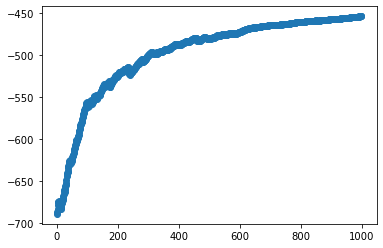

In [123]:
compute_gradient(X,Y,α = 0.00005,num_step = 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

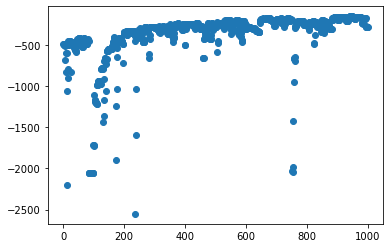

In [124]:
compute_gradient(X,Y,α = 0.005,num_step = 1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

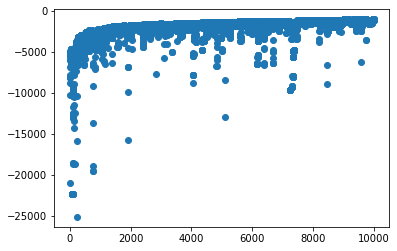

In [723]:
compute_gradient(X,Y,α = 0.005,num_step = 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

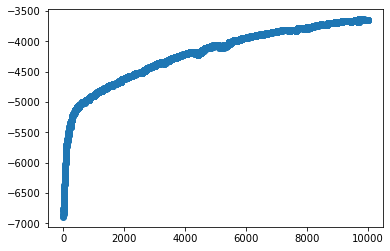

In [125]:
compute_gradient(X,Y,α = 0.00005,num_step = 10000)

In [127]:
β = logistic_regression(X,Y,0.005,10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [128]:
ll = log_likelihood(X,Y,β,59999)
ll

-7610.25891479531

In [11]:
def predict(filename):
    df_test = pd.read_csv(filename)
    test_doc_list = df_test['email_text'].to_list()
    matrix = construct_term_doc(test_doc_list)
    result_list = []
    for i in range(len(test_doc_list)):
        yhat = sigmoid(matrix[i,:],β)
        if yhat >= 0.5:
            result_list.append(1)
        else:
            result_list.append(0)
    return result_list

#### Prediction on Test Data

In [735]:
test_data = pd.read_csv('test.csv')
predicted_df = pd.DataFrame({'uid_email':test_data['uid_email']})

In [ ]:
predicted_df['party_affiliation'] = predict('test.csv')
predicted_df['party_affiliation'] = predicted_df['party_affiliation'].map({0:'Democratic Party',1:'Republican Party'})
predicted_df

In [ ]:
predicted_df.to_csv('submission9.csv', index=False)

#### Prediction on Validation Dataset

In [758]:
result = predict('dev.csv')
prediction_arr = np.array(result)

0it [00:00, ?it/s]

In [95]:
data = pd.read_csv('dev.csv')
actual_arr = data['party_affiliation'].map({'Democratic Party':0,'Republican Party':1}).to_numpy()
actual_arr

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 1, 0, 0, 1, 0, 1, 0, 0, 0, 0])

In [20]:
def f1_score(actual, prediction):
    
    tp = np.sum((actual == 1) & (prediction == 1))
    fp = np.sum((actual != 1) & (prediction == 1))
    fn = np.sum((prediction != 1) & (actual == 1))
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return f1

In [763]:
f1_score(actual_arr, prediction_arr)

0.8640586157268089

## Part 3: Logistic Regression with PyTorch

In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

#### Setting up the Data

In [85]:
def to_sparse_tensor(sparse_numpy):
    sparse_tensor = torch.from_numpy(sparse_numpy.astype(np.float32)).to_sparse()
    return sparse_tensor

In [86]:
# Term Document Sparse Tensor
tensor_X = to_sparse_tensor(X).to_dense()

In [87]:
tensor_Y = torch.from_numpy(Y.astype(np.float32)).reshape(59999,1) 

In [263]:
dev = pd.read_csv('dev.csv')
dev_doc_list = dev['email_text'].to_list()
dev_matrix = construct_term_doc(dev_doc_list)

0it [00:00, ?it/s]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0.,
        0

In [267]:
dev_csr = csr_matrix(dev_matrix)
scipy.sparse.save_npz('dev_sparse_matrix.npz', dev_csr)

In [88]:
X_test = scipy.sparse.load_npz('dev_sparse_matrix.npz').toarray()

In [89]:
X_test = to_sparse_tensor(X_test).to_dense()
X_test

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [97]:
#Y_test = torch.from_numpy(actual_arr.astype(np.float32)).reshape(1,20000)

#### Building the Logistic Regression Neural Network

In [90]:
class LogisticRegression(nn.Module):
    
    def __init__(self):
        super(LogisticRegression, self).__init__()
        #self.x_layer = torch.nn.Linear(tensor_X.shape[1], tensor_X.shape[1])
        #self.y_layer = torch.nn.Linear(tensor_X.shape[1],tensor_X.shape[0])
        self.linear = torch.nn.Linear(tensor_X.shape[1], 1)
            
    def forward(self, inputs):
        output = torch.sigmoid(self.linear(inputs))
        return output

#### Setting up the Training

In [91]:
model = LogisticRegression()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001)

  0%|          | 0/5 [00:00<?, ?it/s]

[1, 1000] loss: 306.76850
          f1 score: 0.599195710455764
[1, 2000] loss: 335.27551
          f1 score: 0.7561904761904763
[1, 3000] loss: 261.15293
          f1 score: 0.7513150204558738
[1, 4000] loss: 228.00477
          f1 score: 0.6940154440154439
[1, 5000] loss: 212.73296
          f1 score: 0.7405247813411078
[2, 2000] loss: 211.42487
          f1 score: 0.8147665014349074
[2, 4000] loss: 221.93898
          f1 score: 0.8134945894334819
[2, 6000] loss: 200.52911
          f1 score: 0.8161348252521066
[2, 8000] loss: 187.66145
          f1 score: 0.8065301446369755
[2, 10000] loss: 203.18120
          f1 score: 0.822179203539823
[3, 3000] loss: 171.24570
          f1 score: 0.8320538720538722
[3, 6000] loss: 191.94405
          f1 score: 0.8191609977324262
[3, 9000] loss: 161.31903
          f1 score: 0.8279747183292112
[3, 12000] loss: 176.63489
          f1 score: 0.8376907763769077
[3, 15000] loss: 172.68644
          f1 score: 0.8370350548568372
[4, 4000] loss: 183.5854

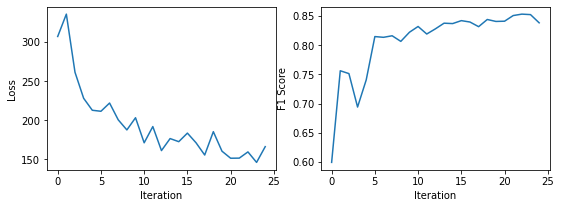

In [96]:
loss_history = []
f1_history = []
running_loss = 0.0 
epochs = range(5)

for epoch in tqdm(epochs):

    for i in range(5000):
        index = random.randint(0,tensor_X.shape[0] - 1)
        X_train = tensor_X[index,:]
        Y_train = tensor_Y[index,0].unsqueeze(0)

        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, Y_train)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            loss_history.append(running_loss)
            print(f'[{epoch + 1}, {(epoch + 1)*(i+1)}] loss: {running_loss:.5f}')
            running_loss = 0.0 

            model.eval()
            with torch.no_grad():
                Y_pred = model(X_test)
                f1 = f1_score(actual_arr, Y_pred.round().detach().numpy().reshape(20000,))
                print(f'          f1 score: {f1}')
                f1_history.append(f1)
            model.train()

torch.save(model.state_dict(), 'model')

plt.subplots(figsize=(9, 3))
    
plt.subplot(1, 2, 1)
plt.plot(range(len(loss_history)),loss_history)
plt.xlabel('Iteration') 
plt.ylabel('Loss') 
    
plt.subplot(1, 2, 2)
plt.plot(range(len(f1_history)),f1_history)
plt.xlabel('Iteration') 
plt.ylabel('F1 Score') 
plt.show()

In [422]:
test = pd.read_csv('test.csv')
test_doc_list = test['email_text'].to_list()
test_matrix = construct_term_doc(test_doc_list)

0it [00:00, ?it/s]

In [423]:
test_csr = csr_matrix(test_matrix)
scipy.sparse.save_npz('test_sparse_matrix.npz', test_csr)

In [424]:
test_X = scipy.sparse.load_npz('test_sparse_matrix.npz').toarray()

In [425]:
test_X = to_sparse_tensor(test_X).to_dense()
test_X

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [426]:
final_model = LogisticRegression()
final_model.load_state_dict(torch.load('model'))
final_model.eval()

LogisticRegression(
  (linear): Linear(in_features=14432, out_features=1, bias=True)
)

In [427]:
with torch.no_grad():
    output = final_model(test_X)
    prediction = output.round().detach().numpy().reshape(20000,)
prediction

array([0., 0., 1., 0., 0., 0., 1., 0., 1., 0., ..., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0.], dtype=float32)

In [429]:
test_data = pd.read_csv('test.csv')
p3_df = pd.DataFrame({'uid_email':test_data['uid_email']})

In [430]:
p3_df['party_affiliation'] = prediction
p3_df['party_affiliation'] = p3_df['party_affiliation'].map({0:'Democratic Party',1:'Republican Party'})
p3_df

,uid_email,party_affiliation
0,5dfbe09ce5b500dd3dcb9f93c8fb185f,Democratic Party
1,07e48f4183b98420a18503791fb412f6,Democratic Party
2,b58c8607d96a414db0e9cc10108c35f5,Republican Party
3,3901d9539d69ada89e5c82e2f1ca950d,Democratic Party
4,6a3e8e6f31381e84a34571deee0f1238,Democratic Party
...,...,...
19995,9b11afd6a84d3806034d9080f4e9752a,Republican Party
19996,888cacc2d660bf040f04ef1caf6ce844,Democratic Party
19997,712dc83f7a455870373c7a9eb30445d7,Republican Party
19998,0bf3265244c2c06fff084c5a79a6387c,Democratic Party


In [431]:
p3_df.to_csv('p3_submission.csv', index = False)

## Training and Experiments

In [99]:
def train_model(weight_decay,lr):
    model = LogisticRegression()
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = weight_decay)
    
    loss_history = []
    f1_history = []
    running_loss = 0.0 
    epochs = range(1)

    for epoch in epochs:

        for i in tqdm(range(25000)):
            index = random.randint(0,tensor_X.shape[0] - 1)
            X_train = tensor_X[index,:]
            Y_train = tensor_Y[index,0].unsqueeze(0)

            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, Y_train)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 1000 == 999:
                loss_history.append(running_loss)
                running_loss = 0.0 

                model.eval()
                with torch.no_grad():
                    Y_pred = model(X_test)
                    f1 = f1_score(actual_arr, Y_pred.round().detach().numpy().reshape(20000,))
                    f1_history.append(f1)
                model.train()
    
    plt.subplots(figsize=(9, 3))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(len(loss_history)),loss_history)
    plt.xlabel('Iteration') 
    plt.ylabel('Loss') 
    
    plt.subplot(1, 2, 2)
    plt.plot(range(len(f1_history)),f1_history)
    plt.xlabel('Iteration') 
    plt.ylabel('F1 Score') 
    plt.show()

#### 1. Comparing L2 Penalty (Weight Decay)

  0%|          | 0/25000 [00:00<?, ?it/s]

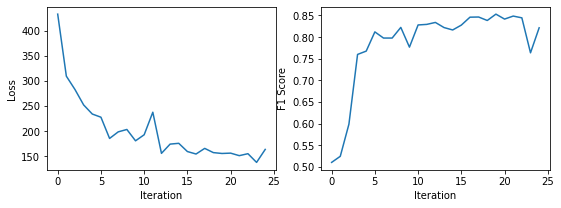

In [100]:
train_model(weight_decay = 0, lr = 0.001)

  0%|          | 0/25000 [00:00<?, ?it/s]

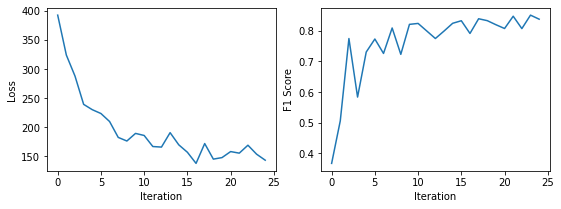

In [103]:
train_model(weight_decay = 0.001, lr = 0.001)

  0%|          | 0/25000 [00:00<?, ?it/s]

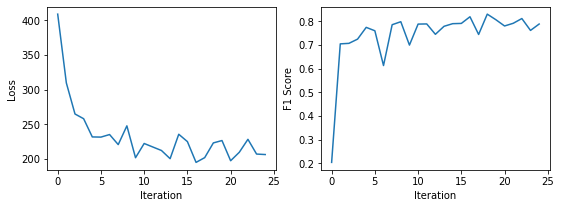

In [102]:
train_model(weight_decay = 0.1, lr = 0.001)

#### 2. Comparing Learning Rate

  0%|          | 0/25000 [00:00<?, ?it/s]

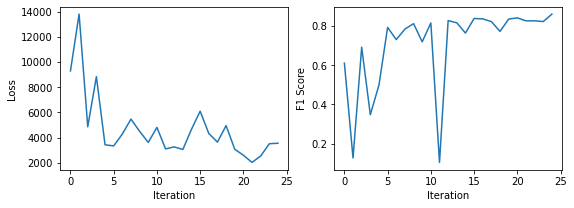

In [29]:
train_model(weight_decay = 0, lr = 0.1)

  0%|          | 0/25000 [00:00<?, ?it/s]

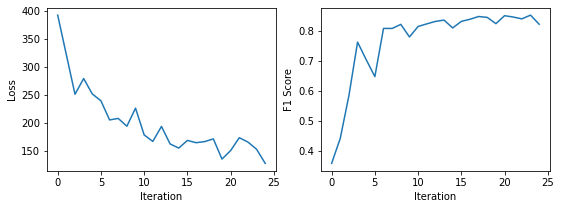

In [30]:
train_model(weight_decay = 0, lr = 0.001)

  0%|          | 0/25000 [00:00<?, ?it/s]

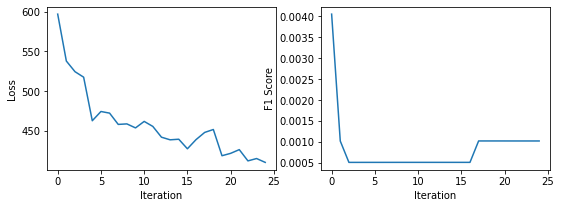

In [35]:
train_model(weight_decay = 0, lr = 0.00001)

#### 3. Comparing Optimizers

In [105]:
def train_model_2(model, optimizer):
    
    loss_history = []
    f1_history = []
    running_loss = 0.0 
    epochs = range(1)

    for epoch in epochs:

        for i in tqdm(range(25000)):
            index = random.randint(0,tensor_X.shape[0] - 1)
            X_train = tensor_X[index,:]
            Y_train = tensor_Y[index,0].unsqueeze(0)

            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, Y_train)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 1000 == 999:
                loss_history.append(running_loss)
                running_loss = 0.0 

                model.eval()
                with torch.no_grad():
                    Y_pred = model(X_test)
                    f1 = f1_score(actual_arr, Y_pred.round().detach().numpy().reshape(20000,))
                    f1_history.append(f1)
                model.train()

    plt.subplots(figsize=(9, 3))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(len(loss_history)),loss_history)
    plt.xlabel('Iteration') 
    plt.ylabel('Loss') 
    
    plt.subplot(1, 2, 2)
    plt.plot(range(len(f1_history)),f1_history)
    plt.xlabel('Iteration') 
    plt.ylabel('F1 Score') 
    plt.show()

  0%|          | 0/25000 [00:00<?, ?it/s]

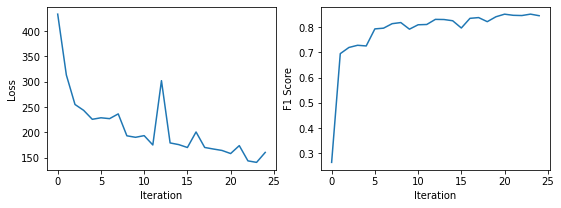

In [109]:
model_2 = LogisticRegression()
optimizer = optim.SGD(model_2.parameters(), lr = 0.001)
train_model_2(model_2, optimizer)

  0%|          | 0/25000 [00:00<?, ?it/s]

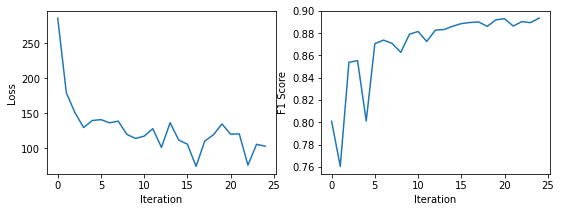

In [110]:
model_2 = LogisticRegression()
optimizer = optim.RMSprop(model_2.parameters(), lr = 0.001)
train_model_2(model_2, optimizer)

  0%|          | 0/25000 [00:00<?, ?it/s]

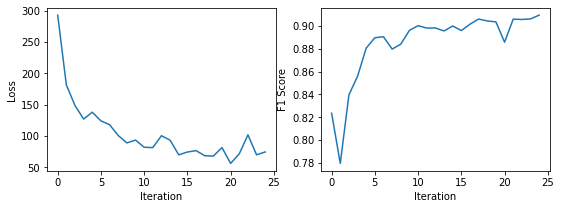

In [111]:
model_2 = LogisticRegression()
optimizer = optim.Adam(model_2.parameters(), lr = 0.001)
train_model_2(model_2, optimizer)

#### 4. Comparing Tokenizations

In [6]:
token_dict = Counter() # Counting all words for all documents and putting into a dictionary
for doc in doc_list:
    token_dict.update(Counter(tokenize(doc.lower())))

In [7]:
uniq_words = set() # A set of unique words for all documents
for doc in tqdm(doc_list):
    uniq_words.update(tokenize(doc.lower()))
    
words_index_dict = {}
for i, word in list(enumerate(sorted(uniq_words))):
    words_index_dict[word] = i

  0%|          | 0/59999 [00:00<?, ?it/s]

In [8]:
def construct_lame_term_doc(docs):    
    row, col, val = [], [], []
    for index, text in tqdm(enumerate(docs)):
        text = text.lower()
        count_dict = Counter()
        words_list = tokenize(text)
        count_dict.update(Counter(words_list))
        for word, count in count_dict.items():
            try:
                col.append(words_index_dict[word])
            except:
                continue
            row.append(index)
            val.append(count)

    matrix = (csr_matrix((val, (row, col)),shape = (len(docs),len(words_index_dict)))).toarray()
    matrix = np.append(matrix, np.ones((len(docs),1)), axis = 1)
    return matrix

In [11]:
lame_term_doc = construct_lame_term_doc(doc_list[:10000])

0it [00:00, ?it/s]

In [51]:
tensor_X = to_sparse_tensor(lame_term_doc).to_dense()

In [52]:
tensor_Y = tensor_Y[:10000]

In [113]:
model = LogisticRegression()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001)

In [ ]:
dev = pd.read_csv('dev.csv')
dev_doc_list = dev['email_text'].to_list()
dev_matrix = construct_lame_term_doc(dev_doc_list[:10000])

In [58]:
X_test = to_sparse_tensor(dev_matrix).to_dense()

In [61]:
actual_arr = actual_arr[:10000]

  0%|          | 0/1 [00:00<?, ?it/s]

[1, 1000] loss: 460.36901
          f1 score: 0.6176836861768369
[1, 2000] loss: 309.74031
          f1 score: 0.6708229426433915
[1, 3000] loss: 290.53265
          f1 score: 0.48266908996494867
[1, 4000] loss: 299.10066
          f1 score: 0.7453381575285276
[1, 5000] loss: 239.63379
          f1 score: 0.7429920330480968
[1, 6000] loss: 308.05284
          f1 score: 0.5116634799235181
[1, 7000] loss: 234.98454
          f1 score: 0.8016830294530155
[1, 8000] loss: 200.19338
          f1 score: 0.7853557720696781
[1, 9000] loss: 200.55800
          f1 score: 0.7909407665505226
[1, 10000] loss: 298.54822
          f1 score: 0.821463897131553


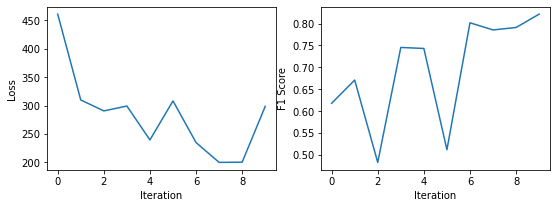

In [73]:
loss_history = []
f1_history = []
running_loss = 0.0 
epochs = range(1)

for epoch in tqdm(epochs):

    for i in range(10000):
        index = random.randint(0,tensor_X.shape[0] - 1)
        X_train = tensor_X[index,:]
        Y_train = tensor_Y[index,0].unsqueeze(0)

        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, Y_train)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            loss_history.append(running_loss)
            print(f'[{epoch + 1}, {(epoch + 1)*(i+1)}] loss: {running_loss:.5f}')
            running_loss = 0.0 

            model.eval()
            with torch.no_grad():
                Y_pred = model(X_test)
                f1 = f1_score(actual_arr, Y_pred.round().detach().numpy().reshape(10000,))
                print(f'          f1 score: {f1}')
                f1_history.append(f1)
            model.train()

plt.subplots(figsize=(9, 3))
    
plt.subplot(1, 2, 1)
plt.plot(range(len(loss_history)),loss_history)
plt.xlabel('Iteration') 
plt.ylabel('Loss') 
    
plt.subplot(1, 2, 2)
plt.plot(range(len(f1_history)),f1_history)
plt.xlabel('Iteration') 
plt.ylabel('F1 Score') 
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

[1, 1000] loss: 393.33230
          f1 score: 0.07465618860510807
[1, 2000] loss: 309.38132
          f1 score: 0.5404619021640299
[1, 3000] loss: 276.07131
          f1 score: 0.46189826544533225
[1, 4000] loss: 246.55162
          f1 score: 0.7833194790800775
[1, 5000] loss: 220.45210
          f1 score: 0.7543461829176116
[1, 6000] loss: 210.20751
          f1 score: 0.7821164174771374
[1, 7000] loss: 199.45041
          f1 score: 0.8057065217391305
[1, 8000] loss: 187.64080
          f1 score: 0.7589339794064204
[1, 9000] loss: 212.93140
          f1 score: 0.7955801104972375
[1, 10000] loss: 174.09488
          f1 score: 0.7719563900666263


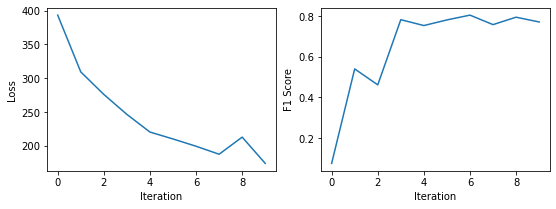

In [114]:
loss_history = []
f1_history = []
running_loss = 0.0 
epochs = range(1)

for epoch in tqdm(epochs):

    for i in range(10000):
        index = random.randint(0,tensor_X.shape[0] - 1)
        X_train = tensor_X[index,:]
        Y_train = tensor_Y[index,0].unsqueeze(0)

        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, Y_train)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            loss_history.append(running_loss)
            print(f'[{epoch + 1}, {(epoch + 1)*(i+1)}] loss: {running_loss:.5f}')
            running_loss = 0.0 

            model.eval()
            with torch.no_grad():
                Y_pred = model(X_test)
                f1 = f1_score(actual_arr, Y_pred.round().detach().numpy().reshape(20000,))
                print(f'          f1 score: {f1}')
                f1_history.append(f1)
            model.train()

plt.subplots(figsize=(9, 3))
    
plt.subplot(1, 2, 1)
plt.plot(range(len(loss_history)),loss_history)
plt.xlabel('Iteration') 
plt.ylabel('Loss') 
    
plt.subplot(1, 2, 2)
plt.plot(range(len(f1_history)),f1_history)
plt.xlabel('Iteration') 
plt.ylabel('F1 Score') 
plt.show()